In [1]:
import numpy as np

class Forest:
    def __init__(self, lattice_lenght, interaction ,p_death, p_birth, max_size, empty = False, low_canopy = 1):
        self.L = lattice_lenght
        self.y = interaction
        self.pd = p_death
        self.pb = p_birth
        self.S_max = max_size
        self.low_canopy = low_canopy
        self.biomass_evolution = []
        
        #construction
        if empty:
            self.forest = np.zeros((self.L+4,self.L+4))
        else:
            self.forest = np.random.rand(self.L+4,self.L+4)*self.S_max
            
    def neighbors(self,i,j, second = False):
        if second:
            col = [i,i-2,i+2]
            raw = [j,j-2,j+2]
            return [(a,b) for a in col for b in raw][1:]
        else:
            col = [i,i-1,i+1]
            raw = [j,j-1,j+1]
            return [(a,b) for a in col for b in raw][1:]
        
   
    def step(self):
        for i in range(2, self.L+2):
            for j in range(2, self.L+2):
        
                if self.forest[i,j]==0:
                    self.birth(i,j)
                else:
                    self.growth(i,j)
        self.biomass_evolution.append(np.sum(self.forest))
            
    def ReLu(self,x):
        if x>=0:
            return x
        else:
            return 0
            
    def birth(self,i,j):
        if np.random.rand() < self.pb:
            self.forest[i,j] = 0.1
            

    def growth(self,i,j):
        if np.random.rand() < self.pd:
            self.death(i,j)
            
        else:
            ds = self.increment(i,j)
            self.forest[i,j] += ds
            
            if self.forest[i,j] > self.S_max:
                self.death(i,j)
    
    def increment(self,i,j):
        #somma dei size dei primi vicini
        S = 0
        for index in self.neighbors(i,j):
            S += self.forest[index]
        S-=self.forest[i,j]
        
        return self.ReLu( 1- (self.y/8)*S )
        
        
    def death(self,i,j):
        
        S = self.forest[i,j]
        
        to_remove = 0
        to_remove_indeces = []
        
        #gap_formation

        for index in self.neighbors(i,j):
            to_remove += self.forest[index]
            if to_remove > S:
                break
            to_remove_indeces.append(index) 
        
        #second neighbors if nedeed
        if to_remove < S:
            for index in self.neighbors(i,j, second = True):
                to_remove += self.forest[index]
                if to_remove > S:
                    break
                to_remove_indeces.append(index)             
            
        for index in to_remove_indeces:
            self.forest[index] = 0
        self.forest[i,j] = 0
        
    def binary_forest(self):
        return self.forest[2:self.L+2,2:self.L+2] < self.low_canopy

In [2]:
import igraph as ig
from collections import Counter
from scipy.optimize import curve_fit
import seaborn as sns
from time import time
import matplotlib.pyplot as plt

In [3]:
class forest_analizer():
    
    def __init__(self,forest):
        self.forest  = forest
        self.graph = self.to_graph()
        self.holes = self.hole_distribution()
        self.counter, self.hole_dim, self.hole_population = self.ordered_counter()
        self.exp, self.cost = self.fit()
        
    
    def to_graph(self):
        h = self.forest.L
        A = self.forest.binary_forest()
        edges = []
        node_counter = 0
        for i in range(h):
            for j in range(h):
                if j != h-1:
                    if A[i,j] == A[i,j+1] == 1: 
                        edges.append([node_counter , node_counter + 1])
                if i != h-1:
                    if A[i,j] == A[i+1,j] == 1:
                        edges.append([node_counter , node_counter + h])
                if j != h-1 and i != h-1:
                    if A[i,j] == A[i+1,j+1] == 1:
                        edges.append([node_counter , node_counter + h+1])
                if j != 0 and i != h-1:
                    if A[i,j] == A[i+1,j-1] == 1:
                        edges.append([node_counter , node_counter + h-1])


                node_counter += 1
        return ig.Graph(n = node_counter , edges = edges)
    
    def hole_distribution(self):
        components = self.graph.components()
        sizes = np.array(components.sizes())
        sizes = sizes[sizes>1] # not counting cluster made of one elementent, diconnected component in graph
        return sizes

    def powerlaw(self,x, m, c):
        return x**m * c
    
    def ordered_counter(self):
        c = Counter(self.holes)
        c = dict(sorted(c.items(), reverse=True))
        x = np.array(list(c.keys()))
        y = np.array(list(c.values()))
        return (c,x,y)
    
    def fit(self):  
        out, _ = curve_fit(self.powerlaw,self.hole_dim,self.hole_population)
        return out

    def plot_fitting(self, filename = None, log_scale = False ):
        ax = plt.subplot()
        if log_scale:
            plt.xscale('log')
            plt.yscale('log')
        ax.scatter(self.hole_dim,self.hole_population) 
        fit = self.hole_dim**self.exp * self.cost
        ax.plot(self.hole_dim, fit , color='green')
        if filename:
            plt.savefig(filename+'.png')
        plt.show()

In [8]:
lattice_lenght = 100
interaction = 0.1
p_death = 0.01
p_birth = 0.3
max_size = 30
max_epoch = 301


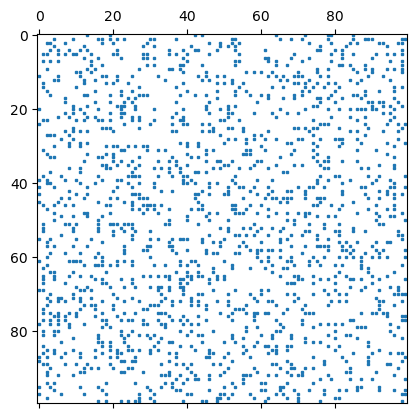

In [5]:
my_forest = Forest(lattice_lenght=lattice_lenght,
                   interaction=interaction,
                   p_death=p_death,
                   p_birth=p_birth,
                   max_size=max_size,
                   low_canopy = 5)
for i in range(30):
    my_forest.step
plt.spy(my_forest.binary_forest(), markersize=2)

17.182997703552246 seconds


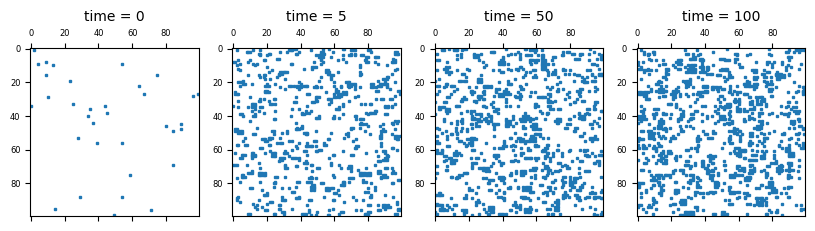

In [9]:
t_0 = time()

#time evolution plot

fig, ax = plt.subplots(1,4, figsize = (10,6))
 

my_forest = Forest(lattice_lenght=lattice_lenght,
                   interaction=interaction,
                   p_death=p_death,
                   p_birth=p_birth,
                   max_size=max_size,
                   low_canopy = 0.1)

t = {0:(0), 5:(1), 50:(2), 100:(3)}

for epoch in range(101):
    if epoch in t.keys():
        ax[t[epoch]].spy(my_forest.binary_forest(), markersize=1.5)
        ax[t[epoch]].set_title(f'time = {epoch}', fontsize = 10)
        ax[t[epoch]].tick_params(axis='both', which='major', labelsize=6)
    my_forest.step()
    
#plt.imshow(my_forest.forest, cmap='jet')
#plt.colorbar()

t_1 = time()
print(t_1-t_0, 'seconds')

plt.show()

In [22]:
fig.savefig('lattice_evolution.png')

In [86]:
#import imageio.v2 as imageio 

In [87]:
#with imageio.get_writer('mygif.gif', mode='I') as writer:
#    for filename in filenames:
#        image = imageio.imread(filename)
#        image = imageio.imread(filename)
#        image = imageio.imread(filename)
#        image = imageio.imread(filename)
#        writer.append_data(image)

In [7]:
def main(lattice_lenght, interaction, p_death, p_birth, max_size, low_canopy):
    my_forest = Forest(lattice_lenght=lattice_lenght,
                   interaction=interaction,
                   p_death=p_death,
                   p_birth=p_birth,
                   max_size=max_size,
                   low_canopy=low_canopy)
    
    for epoch in range(max_epoch):
        my_forest.step()
    
    my_analizer = forest_analizer(my_forest)
    return my_analizer

In [ ]:
#evaluating exponential fitting parameter

In [11]:
lattice_lenght = 100
interaction = 0.1
p_death = 0.01
p_birth = 0.3
max_size = 30
max_epoch = 150

In [12]:
exp = []
t1 = time()

for i in range(5):

    out = main(lattice_lenght, interaction, p_death, p_birth, max_size, low_canopy=0.1)
    exp.append(out.exp)
    
    print('estimated exponent of low_canopy size distribution:', out.exp)
    #sns.displot(out.holes, log_scale = (True,True), bins = 40)

t2 = time()
print('time of execution :',t2-t1,'seconds')
    


estimated exponent of low_canopy size distribution: -1.5789436448915117
estimated exponent of low_canopy size distribution: -1.7069449996436634
estimated exponent of low_canopy size distribution: -1.6869968166501788
estimated exponent of low_canopy size distribution: -1.913280770829851
estimated exponent of low_canopy size distribution: -1.7479901838985834
time of execution : 109.0440001487732 seconds


In [13]:
print('exp media su 5 prove - p_death =',p_death)
print('media' , np.mean(exp))
print('std',np.std(exp))
print('semidispersione', np.max(exp) - np.min(exp))

exp media su 5 prove - p_death = 0.01
media -1.726831283182758
std 0.10868680976057817
semidispersione 0.3343371259383392


estimated exponent of low_canopy size distribution: -1.4092051764247706
time of execution : 18.766997575759888 seconds
estimated exponent of low_canopy size distribution: -1.548912995764865
time of execution : 18.773086547851562 seconds
estimated exponent of low_canopy size distribution: -1.4926216617986645
time of execution : 19.523913860321045 seconds
estimated exponent of low_canopy size distribution: -1.5089089388690968
time of execution : 20.89400362968445 seconds
estimated exponent of low_canopy size distribution: -1.713923951326256
time of execution : 21.067001581192017 seconds
exp media su 5 prove
media -1.5347145448367308
std 0.10050666549445247
semidispersione 0.30471877490148547


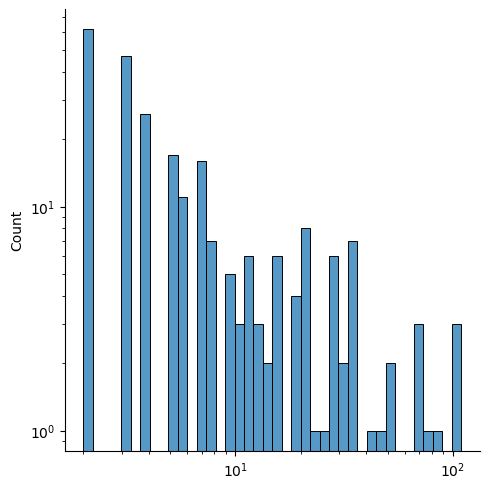

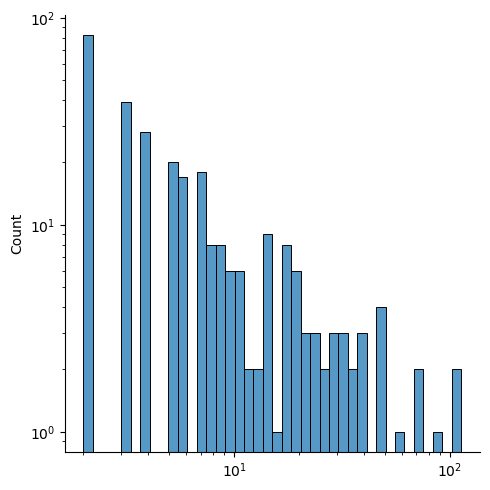

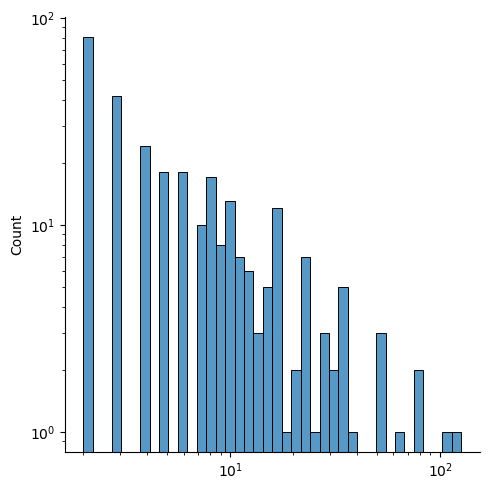

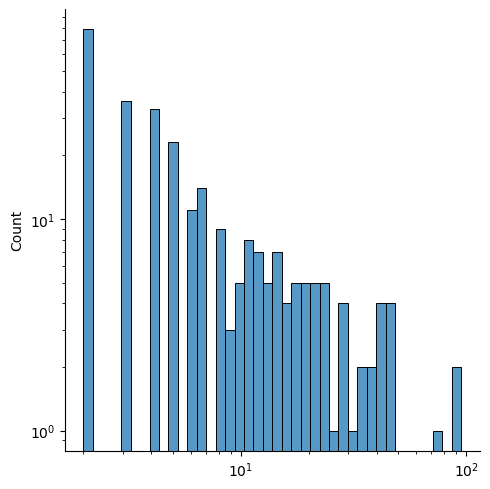

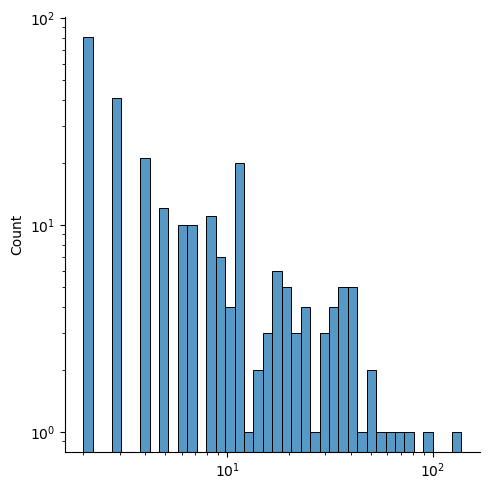

In [14]:
#now with p:death greater
lattice_lenght = 100
interaction = 0.1
p_death = 0.05
p_birth = 0.3
max_size = 30
max_epoch = 150

exp = []
for i in range(5):
    t1 = time()

    out = main(lattice_lenght, interaction, p_death, p_birth, max_size, low_canopy=0.1)
    exp.append(out.exp)
    
    print('estimated exponent of low_canopy size distribution:', out.exp)
    sns.displot(out.holes, log_scale = (True,True), bins = 40)
    t2 = time()
    print('time of execution :',t2-t1,'seconds')

print('exp media su 5 prove')
print('media' , np.mean(exp))
print('std',np.std(exp))
print('semidispersione', np.max(exp) - np.min(exp))

In [16]:
p_death = 0.01
out = main(lattice_lenght, interaction, p_death, p_birth, max_size, low_canopy=0.1)

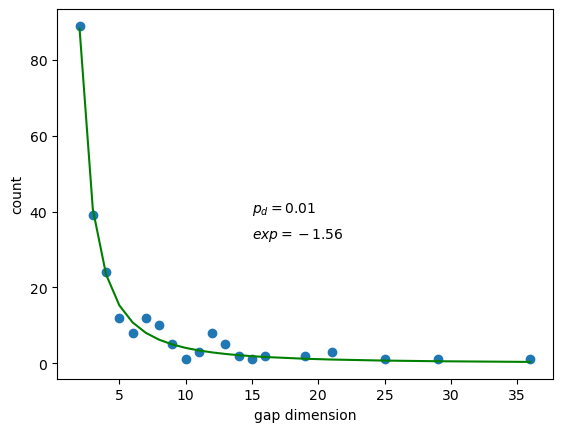

In [17]:
#plt.ylim(bottom = -0.5, top = 4.5)
plt.xlabel('gap dimension')
plt.ylabel('count')
plt.text(15,40,'$p_d = 0.01$' )
plt.text(15,33,'$exp = -1.56$')
out.plot_fitting(log_scale = False, filename = 'fit')


In [21]:
lattice_lenght = 100
interaction = 0.01
p_birth = 0.3
max_size = 30
max_epoch = 300

power distribution exponent: -1.8114
time computation: 38.9170 s


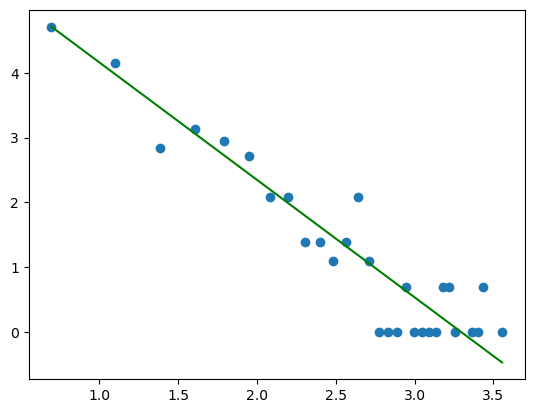

power distribution exponent: -1.3295
time computation: 40.0290 s


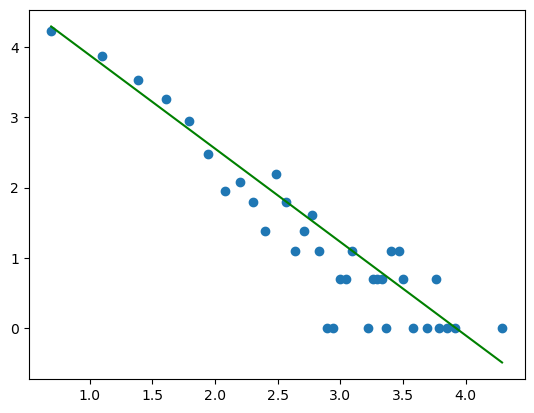

power distribution exponent: -1.2770
time computation: 34.1191 s


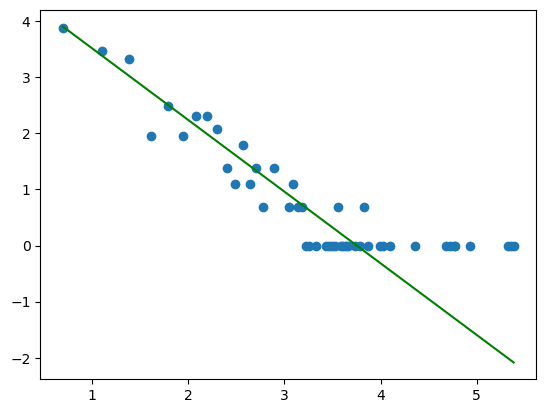

In [25]:
#some other trials

variables = {}
for p_death in [0.01,0.025,0.05,]:
    
    t0 = time()
    
    #construction
    my_forest = my_forest = Forest(lattice_lenght=lattice_lenght,
                   interaction=interaction,
                   p_death=p_death,
                   p_birth=p_birth,
                   max_size=max_size,
                   low_canopy=2)
    
    #evolution
    for epoch in range(max_epoch):
        my_forest.step()
        
    #analysing
    my_analyzer = forest_analizer(my_forest)
    
    variables[p_death]= {'exp':my_analyzer.exp, 'biomass' : my_forest.biomass_evolution}
    
    #print and plot
    print(f'power distribution exponent: {my_analyzer.exp:.4f}')
    print(f'time computation: {time()-t0:.4f} s')
    
    my_analyzer.plot_fitting()

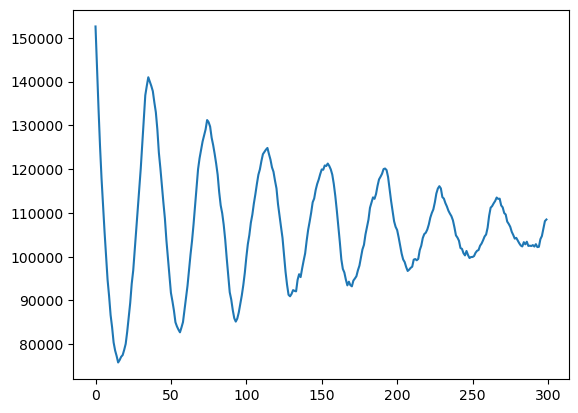

In [26]:
plt.plot(variables[0.01]['biomass'])

In [19]:
lattice_lenght = 100
interaction = 0.1
p_birth = 0.3
p_death= 0.01
max_size = 30
max_epoch = 500

In [20]:
#construction
my_forest = my_forest = Forest(lattice_lenght=lattice_lenght,
               interaction=interaction,
               p_death=p_death,
               p_birth=p_birth,
               max_size=max_size,
               low_canopy=10)

#evolution
for epoch in range(max_epoch):
    my_forest.step()

Text(300, 140000, '$\\gamma = 0.1$')

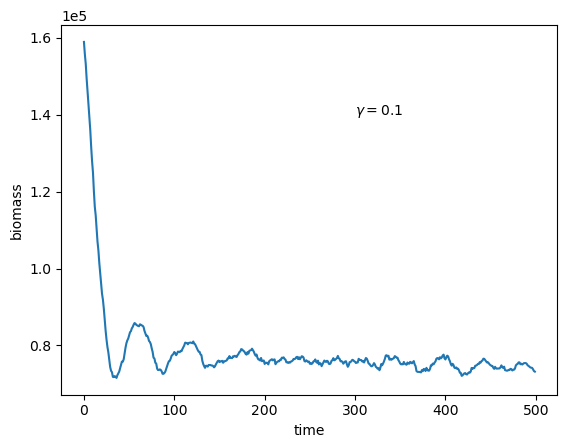

In [21]:
plt.plot(my_forest.biomass_evolution)
plt.xlabel('time')
plt.ticklabel_format(style='scientific', axis='y', scilimits=(0,0))
plt.ylabel('biomass')
plt.text(300,140000,'$\gamma = 0.1$')

transient after 150iterations

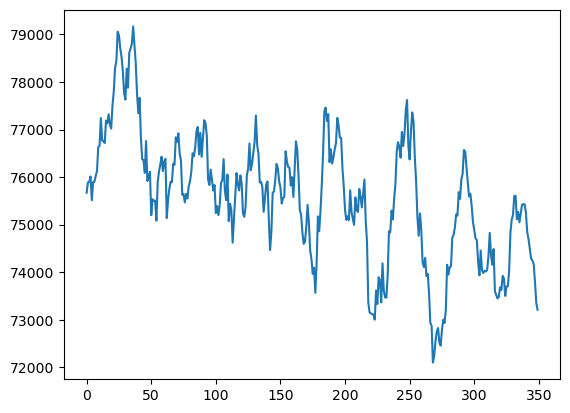

In [22]:
b = my_forest.biomass_evolution
plt.plot(b[150:])

In [25]:
from scipy.fft import fft

In [24]:
freq = fft(b[150:])

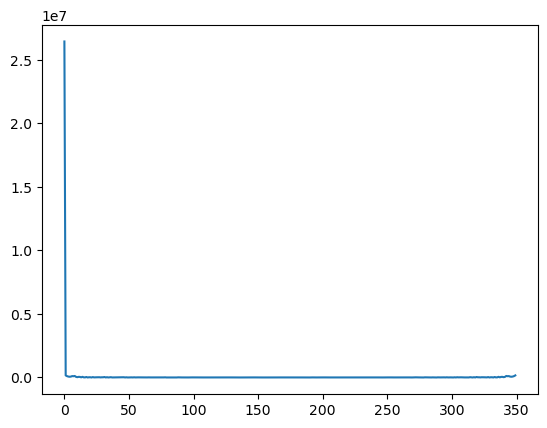

In [25]:
plt.plot(np.abs(freq))

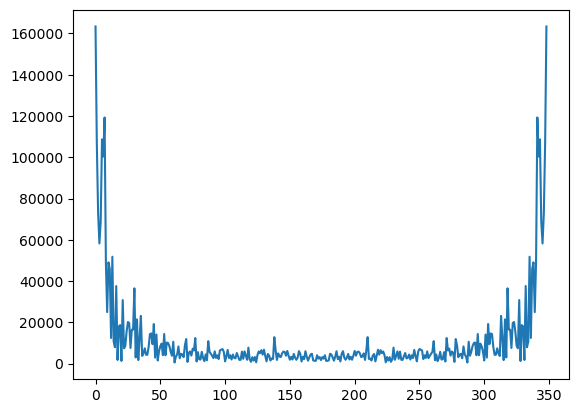

In [26]:
#tolgo la prima frequenza
plt.plot(np.abs(freq[1:]))

In [38]:
#ax = plt.subplot()
#ax.plot(b1_freq[1:])
#plt.yscale('log')
#plt.xscale('log')
#plt.show()

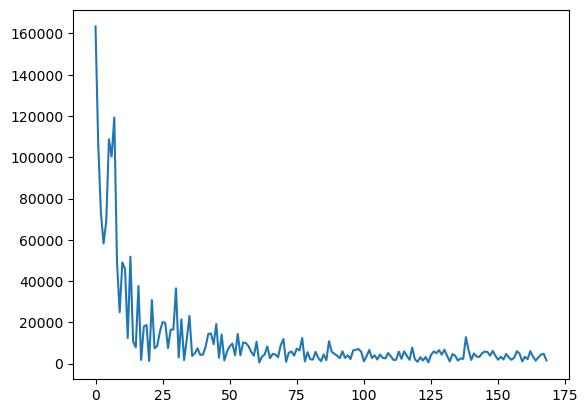

In [27]:
#tengo solo metà dato che è simmetrico
plt.plot(np.abs(freq[1:170]))

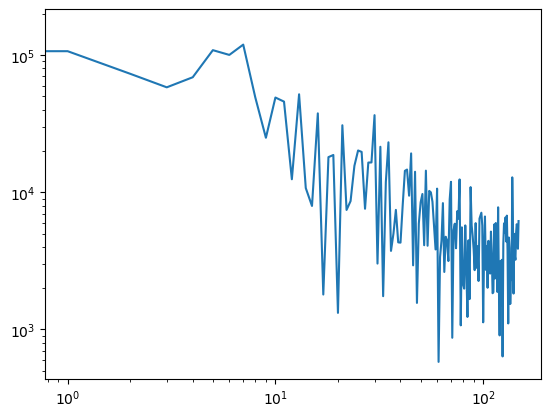

In [28]:
plt.yscale('log')
plt.xscale('log')
plt.plot(np.abs(freq[1:150]))

In [24]:
def one_over_f(x,b,c1,c2):
    return c1/((x+c2)**b)

In [37]:
x_fit = np.arange(10,150)
y_fit = np.abs(freq[10:150])
opt, _ = curve_fit(one_over_f, x_fit, y_fit, p0 = [1,160000,-3.4])

In [38]:
opt

array([ 7.97850094e-01,  1.72303930e+05, -3.43364014e+00])

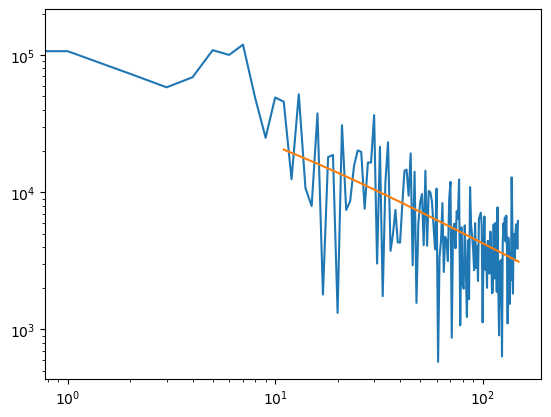

In [43]:
plt.yscale('log')
plt.xscale('log')
plt.plot(np.abs(freq[1:150]))
plt.plot(x_fit[1:], np.abs(opt[1]/(x_fit[1:]-opt[2])**opt[0]))

In [ ]:
#il fit sembra funzionare

In [32]:
#media su 5 simulazioni
lattice_lenght = 100
interaction = 0.1
p_birth = 0.3
p_death= 0.01
max_size = 30
max_epoch = 500

five_forest = []
for i in range(5):
    #construction
    my_forest = my_forest = Forest(lattice_lenght=lattice_lenght,
                   interaction=interaction,
                   p_death=p_death,
                   p_birth=p_birth,
                   max_size=max_size,
                   low_canopy=10)

    #evolution
    for epoch in range(max_epoch):
        my_forest.step()
    five_forest.append(my_forest.biomass_evolution)
    

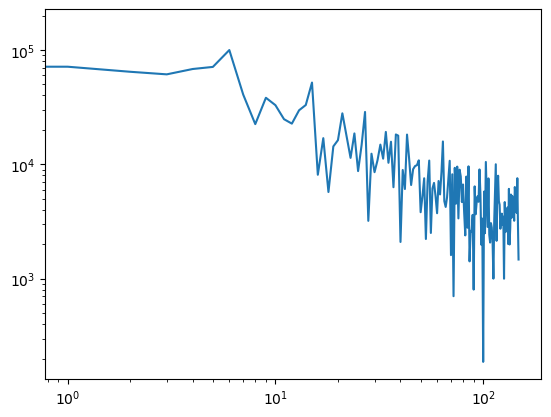

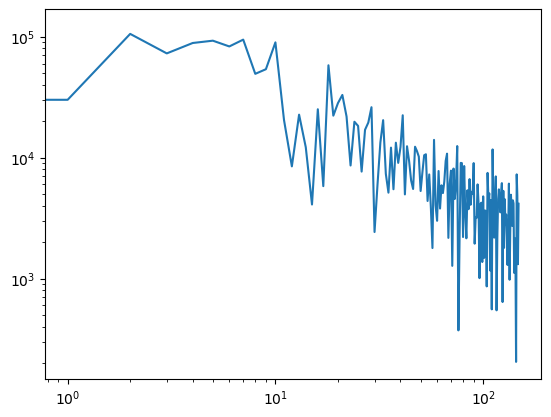

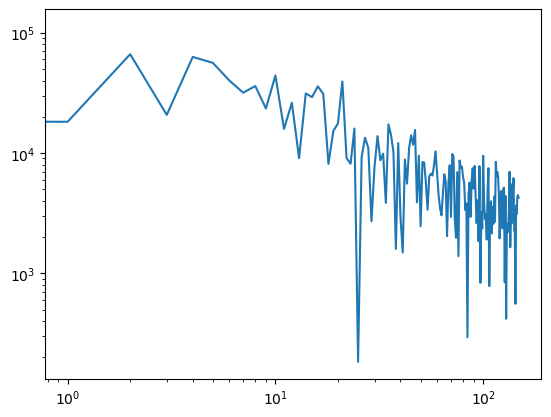

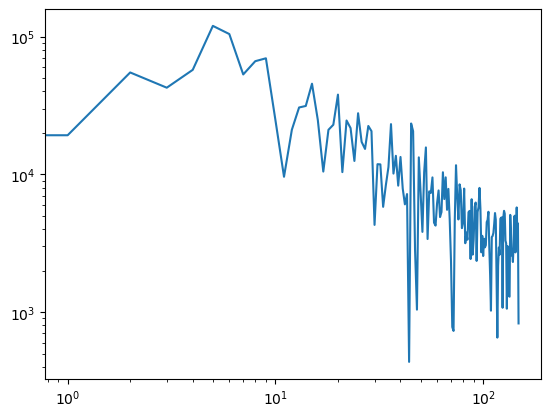

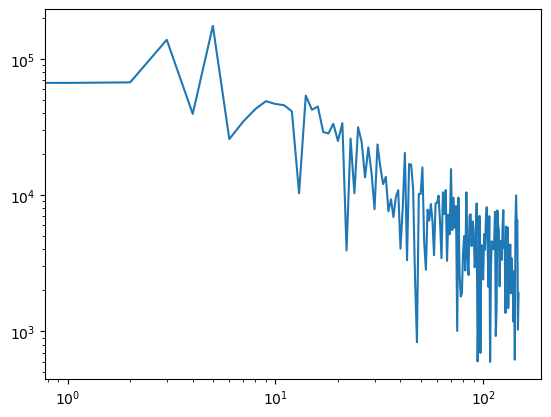

In [33]:
for biomass in five_forest:   
    freq = fft(biomass[150:]) # tengo storia solo dopo 150
    
    x_fit = np.arange(10,150) # uso questo range per tagliare via le prime frequenze o per togliere la parte simmetrica
    y_fit = np.abs(freq[10:150]) #abs per avere l'ampiezza
    plt.yscale('log')
    plt.xscale('log')
    plt.plot(np.abs(freq[1:150]))
    plt.show()

In [60]:
def one_over_f(x,b,c1,c2):
    return c1/((x*c2)**b)

In [61]:
beta= []
for biomass in five_forest:   
    freq = fft(biomass[150:]) # tengo storia solo dopo 150
    x_fit = np.arange(5,150) # uso questo range per tagliare via le prime frequenze o per togliere la parte simmetrica
    y_fit = np.abs(freq[5:150]) #abs per avere l'ampiezza
    opt, _ = curve_fit(one_over_f, x_fit, y_fit, p0 = [1,300000,0.001])
    beta.append(opt)

C:\Users\Daniele\AppData\Local\Temp\ipykernel_11756\1178217213.py:2: RuntimeWarning: invalid value encountered in power
  return c1/((x*c2)**b)


In [62]:
beta 

[array([9.88918434e-01, 5.71597792e+03, 1.40233875e-02]),
 array([1.11073988e+00, 3.75863553e+02, 1.23520301e-03]),
 array([9.03508098e-01, 1.20558009e+06, 5.51347251e+00]),
 array([1.05588169e+00, 2.75002119e+03, 6.66593922e-03]),
 array([9.46331257e-01, 7.21325447e+02, 1.23151697e-03])]

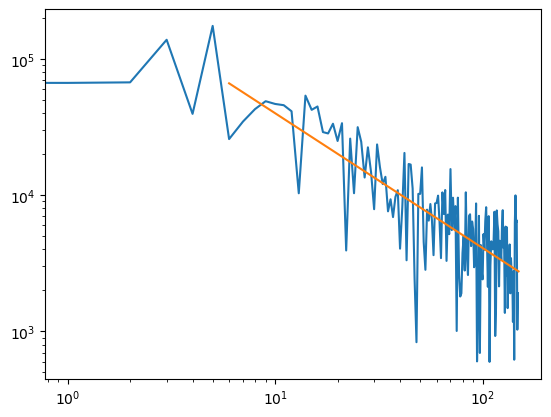

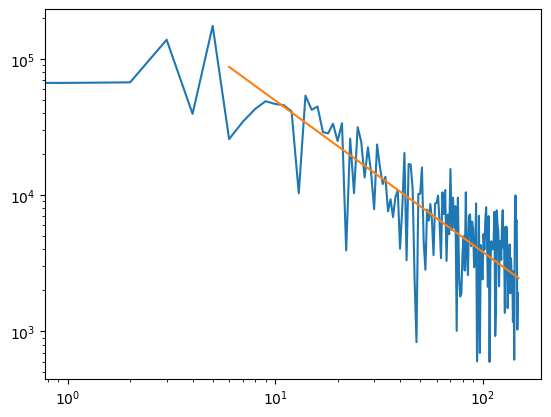

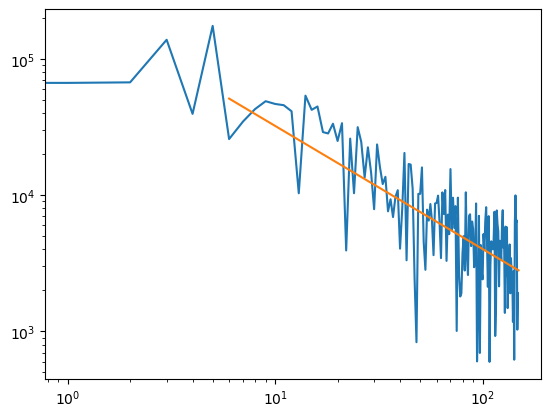

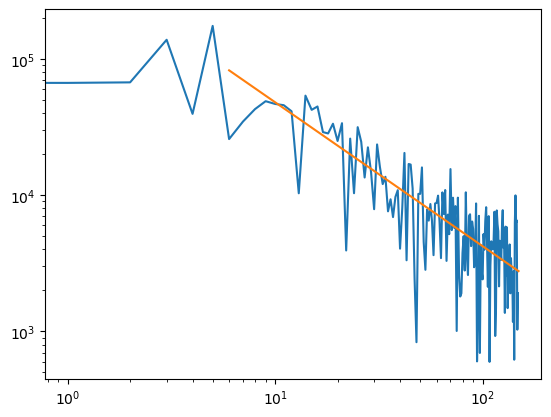

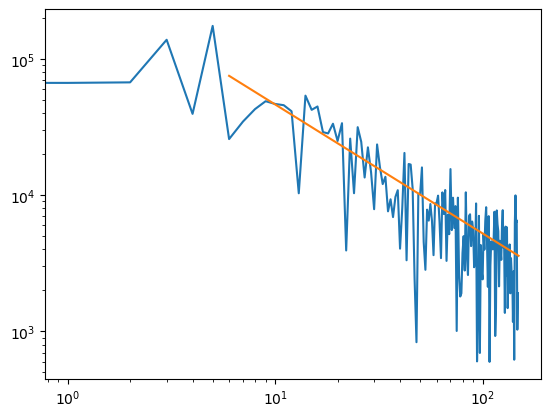

In [64]:
for opt in beta:
    plt.yscale('log')
    plt.xscale('log')
    plt.plot(np.abs(freq[1:150]))
    plt.plot(x_fit[1:], np.abs(opt[1]/(x_fit[1:]*opt[2])**opt[0]))
    plt.show()

In [69]:
beta = np.array(beta)

In [70]:
beta

array([[9.88918434e-01, 5.71597792e+03, 1.40233875e-02],
       [1.11073988e+00, 3.75863553e+02, 1.23520301e-03],
       [9.03508098e-01, 1.20558009e+06, 5.51347251e+00],
       [1.05588169e+00, 2.75002119e+03, 6.66593922e-03],
       [9.46331257e-01, 7.21325447e+02, 1.23151697e-03]])

In [73]:
#esponente
beta[:,0].mean()

1.0010758722395068

In [84]:
beta[:,0].max()-beta[:,0].min()

0.20723178622568605

In [74]:
beta[:,0].std()

0.07442327565627692

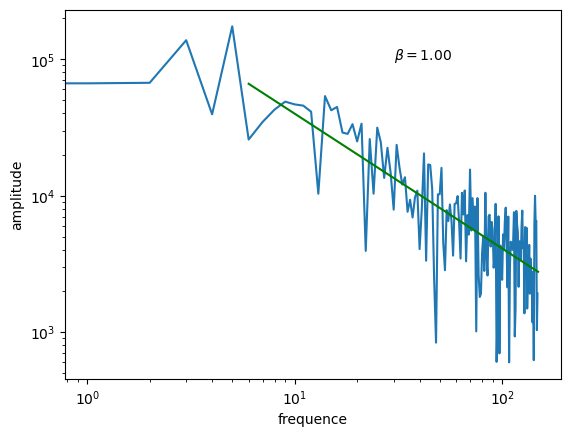

In [83]:
opt = beta[0]
plt.yscale('log')
plt.xscale('log')
plt.plot(np.abs(freq[1:150]))
plt.plot(x_fit[1:], np.abs(opt[1]/(x_fit[1:]*opt[2])**opt[0]), color = 'green')
plt.xlabel('frequence')
plt.ylabel('amplitude')
plt.text(30,100000,r'$\beta = 1.00$')
plt.savefig('freq.png')
plt.show()